# Ford GoBike System Data Exploration
## Data Overview
>This data set includes information about individual rides made in a bike-sharing system covering the `greater San Francisco Bay` area during **february 2019**.<br>

In [24]:
# import libraries 
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read the dataset
df = pd.read_csv('201902-fordgobike-tripdata.csv',parse_dates=['start_time','end_time'])

In [3]:
df.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.789,2019-03-01 06:42:03.056,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


## Dataset Features
* Trip Duration in `seconds`
* Start Time and Date
* Stop Time and Date
* Start Station Name
* End Station Name
* Station ID
* Station Lat/Long
* Bike ID
* User Type: <br>
    `Customer` = 24-hour pass or 3-day pass user<br>
    `Subscriber` = Annual Member
* Gender:<br> 
    `male`<br>
    `female`
* Year of Birth

## Preliminary Wrangling
* **Dropping the NaN records.**
* **Correct all IDs types to objects.**
* **Create Helper functions to help our analysis.**
* **Remove outliers**

In [4]:
df.dropna(inplace=True) ##remove all NaN values
## change types of ids columns from numerical to objects 
df.start_station_id = df.start_station_id.astype(str) 
df.end_station_id = df.end_station_id.astype(str)
df.bike_id = df.bike_id.astype(str)
# change year of birth from float to int for more simplicity
df.member_birth_year = df.member_birth_year.astype(int)

### Helper Functions
[**Haversine Formula**](https://en.wikipedia.org/wiki/Haversine_formula#:~:text=The%20haversine%20formula%20determines%20the,and%20angles%20of%20spherical%20triangles.) <br>The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. I used the stackoverflow solution of this formula to extract the distance between start and end stations.
[stackoverflow solution](https://stackoverflow.com/a/4913653/12001684).

In [5]:
def haversine(longitude_1, latitude_1, longitude_2, latitude_2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.    
    """
    longitude_1, latitude_1, longitude_2, latitude_2 = map(np.radians, [longitude_1, latitude_1, longitude_2, latitude_2])
    longitude_diff = longitude_2 - longitude_1
    latitude_diff = latitude_2 - latitude_1
    a = np.sin(latitude_diff/2.0)**2 + np.cos(latitude_1) * np.cos(latitude_2) * np.sin(longitude_diff/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6367 * c * 1000
    distance = distance.astype(int)
    return distance

In [6]:
def hour_style(x):
    """
    This Function helps to turn the numerical values of 24hour system to AM-PM hour system.
    """
    if x >12:
        return f'{x-12} PM'
    elif x == 0:
        return f'{12} AM'
    elif x == 12:
        return f'{12} PM'
    else: 
        return f'{x} AM'

In [7]:
def Interquartile(df,col):
    ''' 
        This Function is used to detect and remove the outliers using the Interquartile Range rule.
        inputs: col -> name of the column.
        outputs: returns the filtered version of dataframe.
    '''
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df.query(f'(@Q1 - 1.5 * @IQR) <= {col} <= (@Q3 + 1.5 * @IQR)')

## Feature Engineering
>Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.<br>
In our case we use Feature Engineering to Extract additional feature to illustrate data in more appealing way.
* `days`: This feature identify day of a week the trip takes place. for example: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday.
* `duration_min`: represent the time in minutes the trip takes.
* `distance_meter`: trip distance in meters.
* `hour`: hour at which trip started in 12 hours system.

In [8]:
days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

#create duration columns cacluated in minutes instead seconds
df['duration_min'] = df.duration_sec // 60 

#create column of trips distance in meters
df['distance_meter'] = haversine(df.start_station_longitude,df.start_station_latitude,
                             df.end_station_longitude,df.end_station_latitude)

#create column shows the day of week trips happened
df['day'] = df['start_time'].dt.dayofweek
df.day = df.day.apply(lambda x:days[x])

#create column show the hour which trips starts
df['hour'] = df['start_time'].dt.hour
df.hour = df.hour.apply(lambda x :hour_style(x))

#create column contains the ages of customers
df['age'] = 2019 - df.member_birth_year

#drop useless columns
df.drop(columns=['duration_sec','member_birth_year'],inplace=True)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
start_station_latitude,174952.0,37.771220,0.100391,37.317298,37.770407,37.780760,37.797320,37.880222
start_station_longitude,174952.0,-122.351760,0.117732,-122.453704,-122.411901,-122.398279,-122.283093,-121.874119
end_station_latitude,174952.0,37.771414,0.100295,37.317298,37.770407,37.781010,37.797673,37.880222
end_station_longitude,174952.0,-122.351335,0.117294,-122.453704,-122.411647,-122.397437,-122.286533,-121.874119
duration_min,174952.0,11.241461,27.371269,1.000000,5.000000,8.000000,13.000000,1409.000000
distance_meter,174952.0,1688.500029,1096.254274,0.000000,909.000000,1428.000000,2222.000000,69425.000000
age,174952.0,34.196865,10.118731,18.000000,27.000000,32.000000,39.000000,141.000000


## Exploration

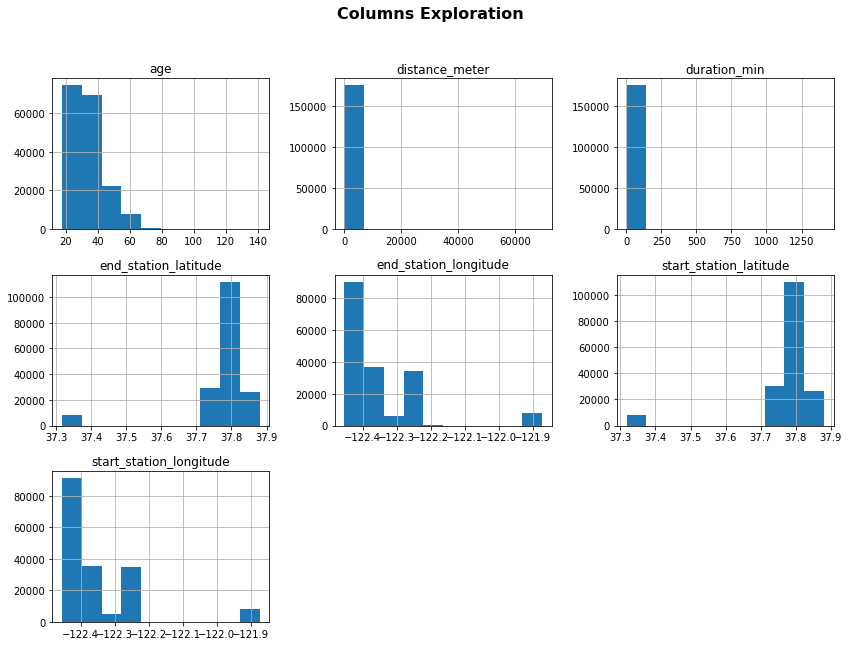

In [10]:
df.hist(figsize=(14,10))
plt.suptitle('Columns Exploration',fontsize=16,fontweight='bold');

In [11]:
## removeing outliers
df = Interquartile(df,'age')
df = Interquartile(df,'distance_meter')
df = Interquartile(df,'duration_min')

## Users Characteristics

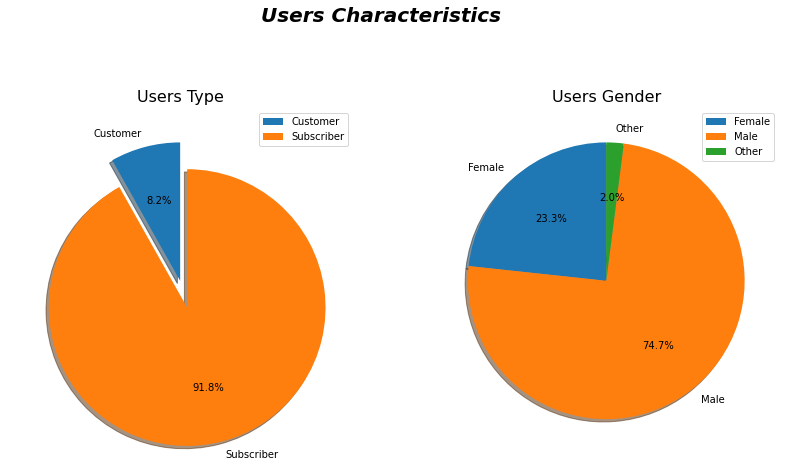

In [12]:
fig = plt.figure(figsize=(14,14))
plt.suptitle('Users Characteristics',fontsize=20,style='italic',fontweight='heavy')
ax = fig.add_subplot(221)
ax.pie(df.groupby('user_type')['user_type'].count(),explode=(0,0.2),
       labels=['Customer','Subscriber'],autopct='%1.1f%%',shadow=True,startangle=90)
plt.title('Users Type',fontsize=16)
plt.legend();

ax = fig.add_subplot(222)
ax.pie(df.groupby('member_gender')['member_gender'].count(),
       labels=['Female','Male','Other'],
       autopct='%1.1f%%',shadow=True,startangle=90)
plt.title('Users Gender',fontsize=16)
plt.legend();

**based on the above pie charts number of subscribers is nine times the costumers. Also most of subscribers is men.**

## **What is the mean age of user?**

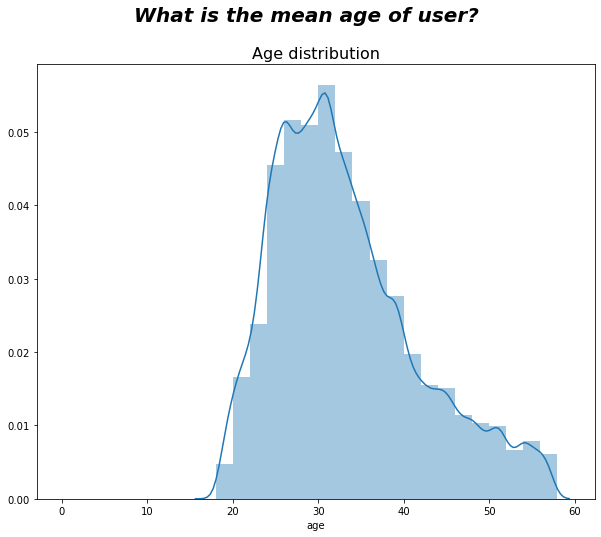

In [13]:
fig = plt.figure(figsize=(10,8))
plt.suptitle('What is the mean age of user?',fontsize=20,style='italic',fontweight='heavy')
bins = np.arange(0,df.age.max()+2,2)
ax = fig.add_subplot(111)
sns.distplot(df.age,bins=bins,ax=ax)
plt.title('Age distribution',fontsize=16);

**It is shown that the majorty of users at their thirties.**

## **How far do they go?**

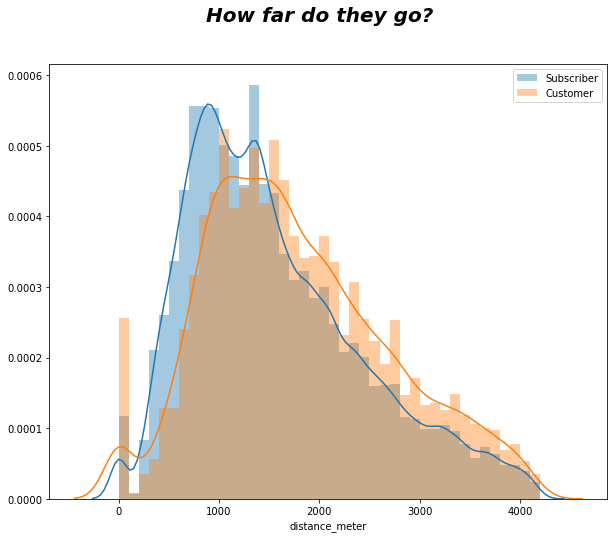

In [14]:
fig = plt.figure(figsize=(10,8))
plt.suptitle('How far do they go?',fontsize= 20,style='italic', fontweight='bold')

distance_meter_subscriber = df.query('user_type == "Subscriber"').distance_meter
distance_meter_customer   = df.query('user_type == "Customer"').distance_meter

bins = np.arange(0,distance_meter_subscriber.max()+100,100) 
ax = fig.add_subplot(111)
sns.distplot(distance_meter_subscriber,bins=bins,label='Subscriber',ax=ax)
sns.distplot(distance_meter_customer,bins=bins,label='Customer',ax=ax)
plt.legend();



**most of users cycle around 1 km for both costumer and subscriber.**

## **How long does the average trip take?**

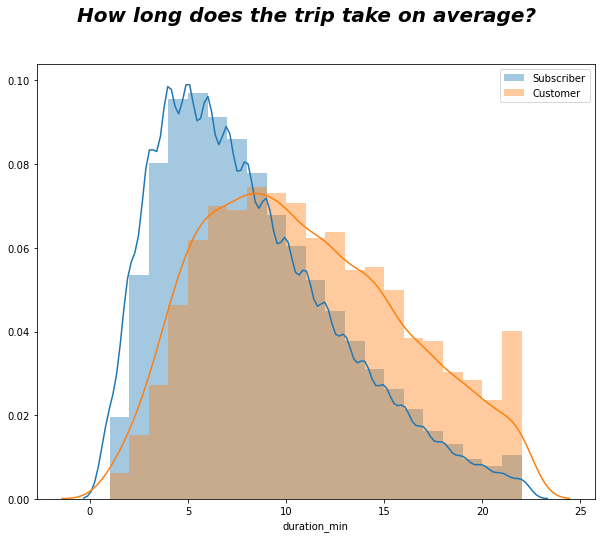

In [15]:
fig = plt.figure(figsize=(10,8))
plt.suptitle('How long does the trip take on average?',fontsize= 20, style='italic',fontweight='bold')

#subscriber or customer
duration_min_subscriber = df.query('user_type == "Subscriber"').duration_min
duration_min_customer = df.query('user_type == "Customer"').duration_min

bins = np.arange(0,duration_min_subscriber.max()+1,1) 
ax = fig.add_subplot(111)
sns.distplot(duration_min_subscriber,bins=bins,label='Subscriber',ax=ax)
sns.distplot(duration_min_customer,bins=bins,label='Customer',ax=ax)
plt.legend();

**most of costumers' trips take around 15 mins, subscribers' trips take around 10 mins.**

## **Which stations are most popular?** 


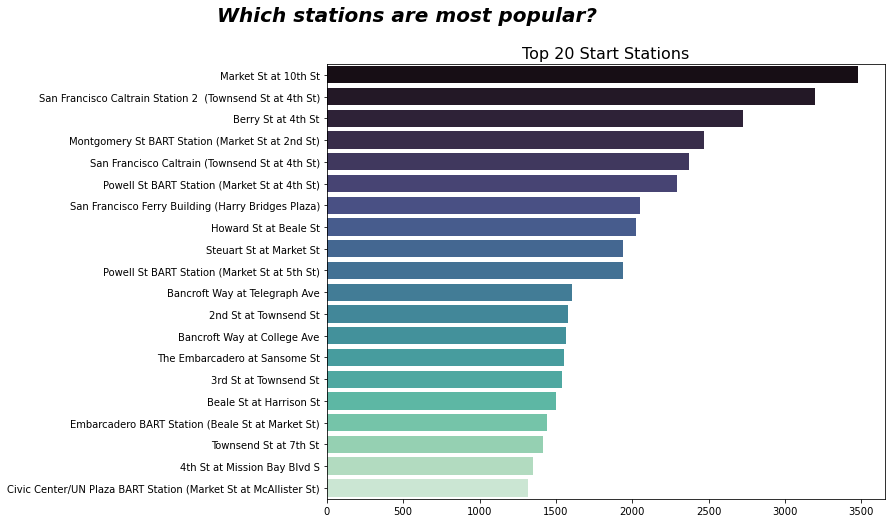

In [16]:
fig = plt.figure(figsize=(10,8))
plt.suptitle('Which stations are most popular?',ha='right',fontsize=20,style='italic',fontweight='heavy')

top_20_start_station = df.start_station_name.value_counts().head(20)
start = top_20_start_station.index
ax = fig.add_subplot(111)
sns.barplot(x=top_20_start_station.values,y=top_20_start_station.index,palette='mako',ax=ax)
plt.title('Top 20 Start Stations',fontsize=16);

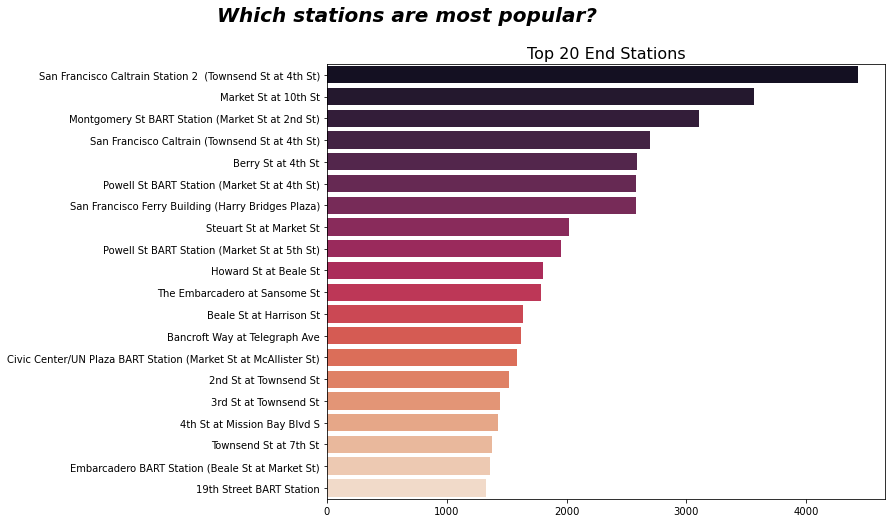

In [17]:
fig = plt.figure(figsize=(10,8))
plt.suptitle('Which stations are most popular?',ha='right',fontsize=20,style='italic',fontweight='heavy')

top_20_end_station = df.end_station_name.value_counts().head(20)
end=top_20_end_station.index
ax = fig.add_subplot(111)
sns.barplot(x=top_20_end_station.values,y=top_20_end_station.index,palette='rocket',ax=ax)
plt.title('Top 20 End Stations',fontsize=16);

Almostly all the start stations are the same of end station, This may indecate some regularity of trips like going to work for example.

## **When are most trips taken in terms of time of day?**

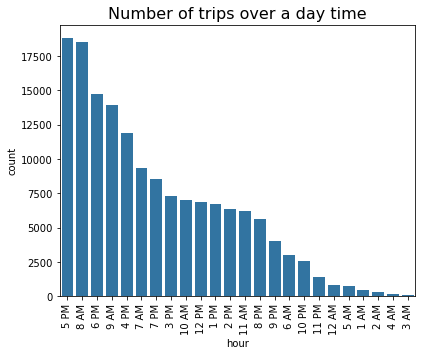

In [18]:
color = sns.color_palette()[0]

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
sns.countplot(data=df, x='hour',order= df.hour.value_counts().index,color=color,ax=ax)
plt.title('Number of trips over a day time', fontsize=16)
plt.xticks(rotation=90);

**Hours aranged according to number of trips happened during them.**

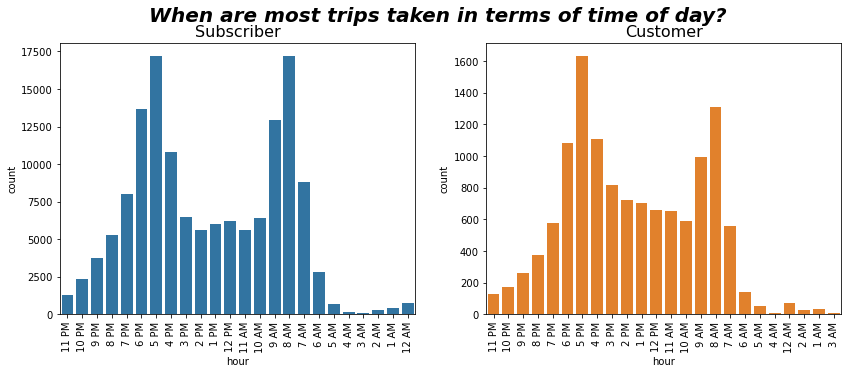

In [19]:
colors= sns.color_palette()[0:2]

fig = plt.figure(figsize=(14,5))
plt.suptitle('When are most trips taken in terms of time of day?',style='italic',fontsize=20,fontweight='heavy')
ax = fig.add_subplot(121)
sns.countplot(x=df.query('user_type=="Subscriber"')['hour'],color=colors[0],ax=ax)
plt.title('Subscriber',fontsize=16)
plt.xticks(rotation=90)

ax = fig.add_subplot(122)
sns.countplot(x=df.query('user_type=="Customer"')['hour'],color=colors[1],ax=ax)
plt.title('Customer',fontsize=16)
plt.xticks(rotation=90);

* **most of trips start between 4-6 PM or 7-9 AM.**
* **trips in day have the same pattern for both costumers and subscribers.**

## What is the relation between features of dataset?

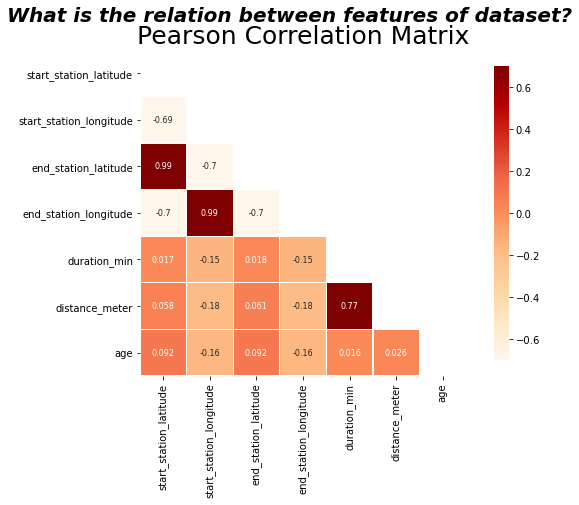

In [20]:
#heatmap to show the correlation coeff of features.
mask = np.zeros_like(df.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(10,6))
plt.suptitle('What is the relation between features of dataset?',fontsize=20,style='italic',fontweight='heavy')
plt.title('Pearson Correlation Matrix',fontsize=25)
sns.heatmap(df.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="OrRd",
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

**Looking at the features, the have no relations between each other; except the location coordinates they have somehow relation it may indecate that most of trips are habben regularly like going to work for example.**

## **What are numbers of trips during Feb in both Subscriber and Costumers?**

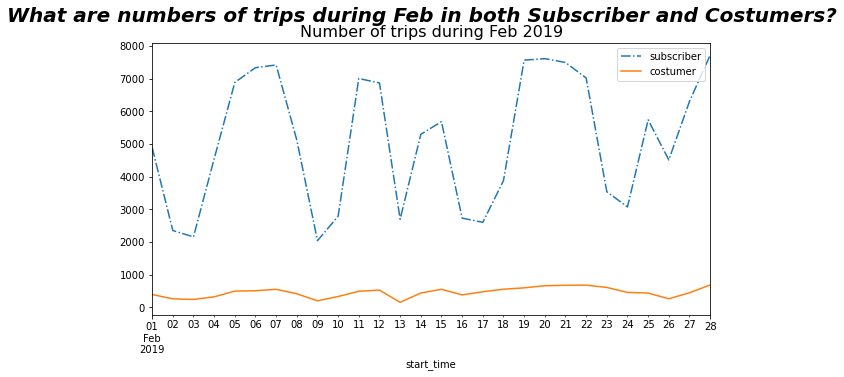

In [21]:
fig = plt.figure(figsize=(10,5))
# resample the data in order to rearange it based on number of trips of user types.
plt.suptitle('What are numbers of trips during Feb in both Subscriber and Costumers?',fontsize=20,style='italic',fontweight='heavy')

subscriber = df.query('user_type=="Subscriber"')
subscriber.resample('D',on='start_time')['bike_id'].count().plot(ls='-.',label='subscriber')
costumer = df.query('user_type=="Customer"')
costumer.resample('D',on='start_time')['bike_id'].count().plot(label='costumer')
plt.title('Number of trips during Feb 2019',fontsize=16)
plt.legend(loc = 'upper right');

**The above graph show the daily report of numbers of trips during Feb 2019. Subscribers graph fluctuates unlike the costumers graph which show some stability during the month.**

## **What days of the week are most rides taken on?**

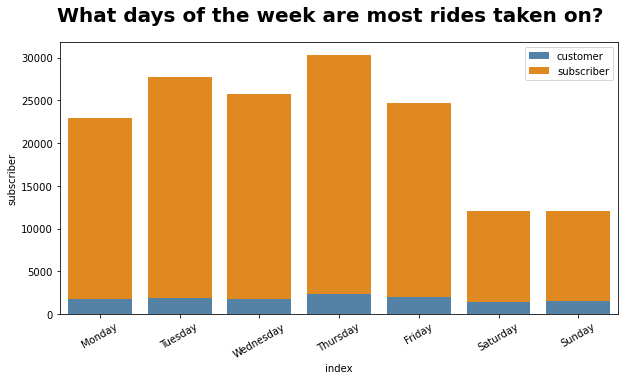

In [22]:
days_label = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig = plt.figure(figsize=(10,5))
plt.suptitle('What days of the week are most rides taken on?',fontsize=20,fontweight='bold')

# Subscribers trips dring days of week.
day_subscriber = df.query('user_type=="Subscriber"')['day'].value_counts().reset_index()
day_subscriber.rename(columns={'day':'subscriber'},inplace=True)

# Customers trips dring days of week.
day_customer = df.query('user_type=="Customer"')['day'].value_counts().reset_index()
day_customer.rename(columns={'day':'customer'},inplace=True)

# join Subscribers and Customers data in one table
users = pd.merge(day_subscriber,day_customer,how='inner',on='index')
users.set_index('index',inplace=True)
users = users.reindex(days_label)

# plot the stacked bar plot of subscribers and customer data.
ax = fig.add_subplot(111)
sns.barplot(users.index,users.customer,color='steelblue',label='customer',ax=ax)
sns.barplot(users.index,users.subscriber,color='darkorange',label='subscriber',ax=ax,**{'bottom':users.customer})
plt.xticks(rotation=30)
plt.legend();

**numbers of costumers trips over a week is steady unlike subscribers trips which decreased significantlly during weekends.**

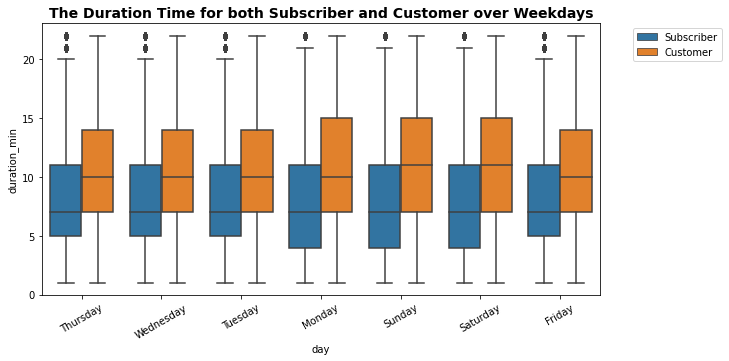

In [23]:
fig = plt.figure(figsize=(10,5))
# boxplot of durantion of trips in both user types.
sns.boxplot(data=df,x='day',y='duration_min',hue='user_type')
plt.title('The Duration Time for both Subscriber and Customer over Weekdays',fontsize=14,fontweight='bold')
plt.xticks(rotation=30)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left');

**Costumers are usually takes more time for their trips than subscribers on avrage during whole week.**

## Conclusion
>**In conclusion, based on visualization statistics; bike sharing usage among subscribers focuses on going to nearby work and return to home later. costumers usage is less directed to going to work but it is not siginficant to numbers of subscribers.**